### Generate Cypher Projection

@cypher:

    CALL gds.graph.create(
    'KG1',
        ["MeSH", "Document", "Protein", "Drug", "Pathway"],
        {
            MENTIONS: {orientation: 'UNDIRECTED'},
            TARGET: {orientation: 'UNDIRECTED'},
            ASSIGNS: {orientation: 'UNDIRECTED'},
            CANDIDATE: {orientation: 'UNDIRECTED'}
        }
    )


In [24]:
from neo4j import GraphDatabase 
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale = 1.5)

In [2]:
class FastRP():
    """Class to run Node Embedding"""
    def __init__(self) -> None:
        self.driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "heart"))

    def close(self) -> None:
        self.driver.close()
    
    @classmethod
    def run_RP(cls, tx) -> any:
        """
        :param cls: is the class
        :param tx: is the transaction (documented in neo4j)
        :return: result.data() is the embeddings
        """
        query = ("""
        CALL gds.fastRP.stream('KG2',
            {
                embeddingDimension: 64
            }
        )
        YIELD nodeId, embedding
        RETURN gds.util.asNode(nodeId).name AS name, LABELS(gds.util.asNode(nodeId)) AS Type, gds.util.asNode(nodeId) AS NodeID, embedding AS Embedding
        """)
        result = tx.run(query)
        return result.data()

    def run_algo(self) -> any:
        """
        :param self:
        :return: result is the dataframe from the degree centrality
        """
        result = self.driver.session().write_transaction(self.run_RP)
        result = pd.DataFrame(result)
        return result

In [3]:
g = FastRP()
rp = g.run_algo()

#editing dataframe
rp["Type"] = rp["Type"].str[0]

In [5]:
rp

,name,Type,NodeID,Embedding
0,Amyloid beta A4 protein,Protein,"{'name': 'Amyloid beta A4 protein', 'id': 'P05...","[-0.07870477437973022, -0.2035229504108429, 0...."
1,Matrix metalloproteinase-9,Protein,"{'name': 'Matrix metalloproteinase-9', 'id': '...","[0.10513068735599518, -0.10704278945922852, 0...."
2,Voltage-dependent P/Q-type calcium channel sub...,Protein,{'name': 'Voltage-dependent P/Q-type calcium c...,"[-0.20204392075538635, -0.10914958268404007, 0..."
3,Extracellular calcium-sensing receptor,Protein,{'name': 'Extracellular calcium-sensing recept...,"[-0.3464478850364685, -0.3766915798187256, 0.5..."
4,"Nitric oxide synthase, brain",Protein,"{'name': 'Nitric oxide synthase, brain', 'id':...","[-0.3551274538040161, -0.090718574821949, 0.04..."
...,...,...,...,...
14768,Metabolism of RNA,Pathway,"{'name': 'Metabolism of RNA', 'id': 'R-HSA-895...","[-0.08468806743621826, 0.22901614010334015, 0...."
14769,Metabolism of proteins,Pathway,"{'name': 'Metabolism of proteins', 'id': 'R-HS...","[-0.03320908918976784, -0.03812050074338913, 0..."
14770,Generic Transcription Pathway,Pathway,"{'name': 'Generic Transcription Pathway', 'id'...","[-0.11231677234172821, 0.35529088973999023, -0..."
14771,RNA Polymerase II Transcription,Pathway,"{'name': 'RNA Polymerase II Transcription', 'i...","[-0.11231677234172821, 0.35529088973999023, -0..."


In [7]:
vectorize = rp["Embedding"]
vectorize = vectorize.to_list()

### Creating UMAP

In [8]:
import umap
from sklearn.preprocessing import StandardScaler

In [9]:
reducer = umap.UMAP()

In [10]:
embedding = reducer.fit_transform(vectorize)

In [11]:
embedding[0:10]

array([[12.913553  ,  0.87188977],
       [ 2.804338  ,  7.6584377 ],
       [ 0.554859  , 10.48667   ],
       [-8.843147  , -3.136667  ],
       [-4.669721  ,  0.33171692],
       [-2.8246915 , -4.8153358 ],
       [-1.6422249 , -0.07477337],
       [ 2.6830268 ,  3.4667156 ],
       [ 5.9821095 , -0.4568727 ],
       [ 2.8862047 ,  4.780101  ]], dtype=float32)

In [15]:
rp['UMAP_x'] = [x[0] for x in list(embedding)]
rp['UMAP_y'] = [x[1] for x in list(embedding)]

In [16]:
proteins = rp[rp["Type"] == "Protein"]
mesh = rp[rp["Type"] == "MeSH"]
pathway = rp[rp["Type"] == "Pathway"]
doc = rp[rp["Type"] == "Document"]
drug = rp[rp["Type"] == "Drug"]

df = pd.concat([doc, drug, pathway, proteins, mesh])

<AxesSubplot:title={'center':'UMAP using FastRP'}, xlabel='UMAP_x', ylabel='UMAP_y'>

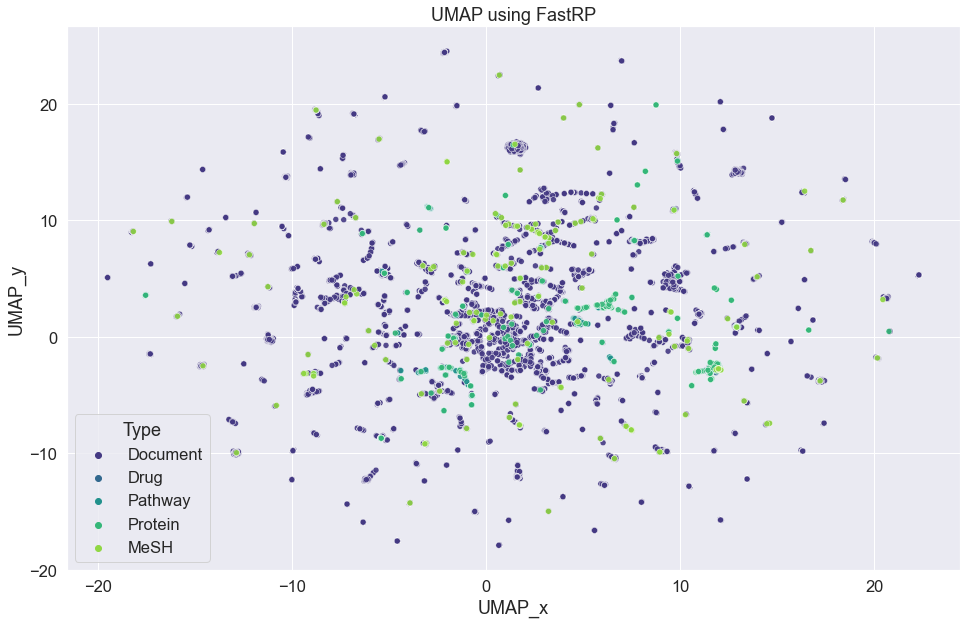

In [25]:
plt.figure(figsize=(16,10))
plt.title("UMAP using FastRP")
sns.scatterplot(
    x="UMAP_x", y="UMAP_y",
    hue="Type",
    palette="viridis",
    data=df,
    legend="full",
    alpha=0.9
)


In [20]:
plt.savefig("results/UMAP.png")

<Figure size 432x288 with 0 Axes>